## Principal Components

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

### PCA using SVD decomposition

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

### Using Scikit-Learn

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

### Explained Variance Ratio

In [10]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

### Choosing the Right Number of Dimensions

In [11]:
## MNIST

import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [12]:
X, y = np.array(mnist["data"]), np.array(mnist["target"])

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

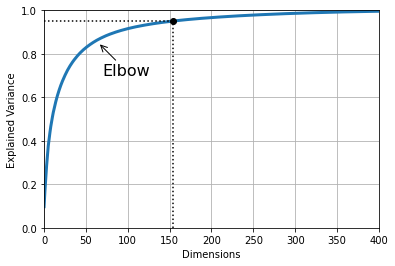

In [15]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [16]:
d

154

You could then set n_components=d and run PCA again. However, there is a much
better option: instead of specifying the number of principal components you want to
preserve, you can set n_components to be a float between 0.0 and 1.0, indicating the
ratio of variance you wish to preserve:

In [17]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

### PCA for Compression

In [18]:
pca.n_components_

154

In [19]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557436

In [20]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [21]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

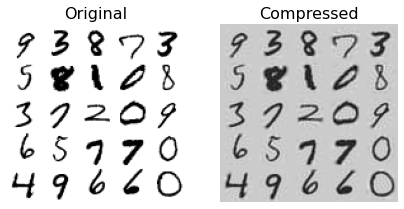

In [22]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

## Incremental PCA

you can split the training
set into mini-batches and feed an IPCA algorithm one mini-batch at a time. This is
PCA 
useful for large training sets, and also to apply PCA online

In [23]:
### split train set into 100 mini-batch

from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

In [24]:
X_reduced = inc_pca.transform(X_train)

### Kernel PCA

In [26]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

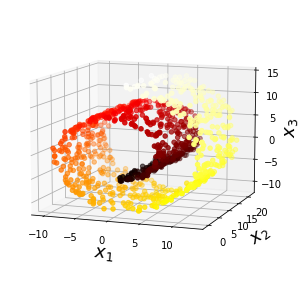

In [29]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

In [30]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

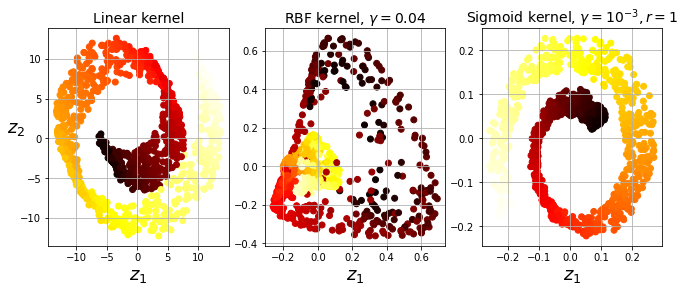

In [31]:

from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

### Selecting a Kernel and Tuning Hyperparameters

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [50]:
clf = Pipeline([("kpca", KernelPCA(n_components=2)),
                ("log_reg", LogisticRegression(solver="lbfgs"))
               ])

param_grid = [{"kpca__gamma": np.linspace(0.03, 0.05, 10),
               "kpca__kernel": ["rbf", "sigmoid"]
              }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [51]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [52]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [53]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576613

### LLE

In [56]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

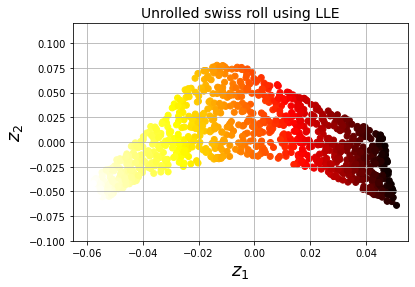

In [57]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

### MDS, Isomap and t-SNE

In [58]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [59]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [60]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

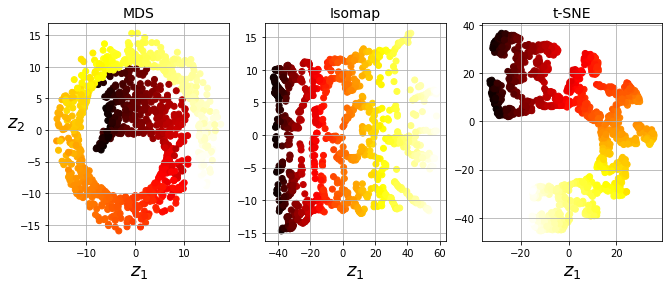

In [61]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

### LDA

In [62]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)